In [ ]:
!pip install -q segmentation-models-pytorch
!pip install -q albumentations
!pip install -q opencv-python
!pip install -q scikit-learn
!pip install -q tifffile
!pip install -q imagecodecs  # ← NEW: Required for compressed TIFF files

print("✅ All libraries installed (including tifffile + imagecodecs)!")

✅ All libraries installed (including tifffile + imagecodecs)!


Found 838 image files and 838 mask files.

Visualizing an example image and its augmented version:


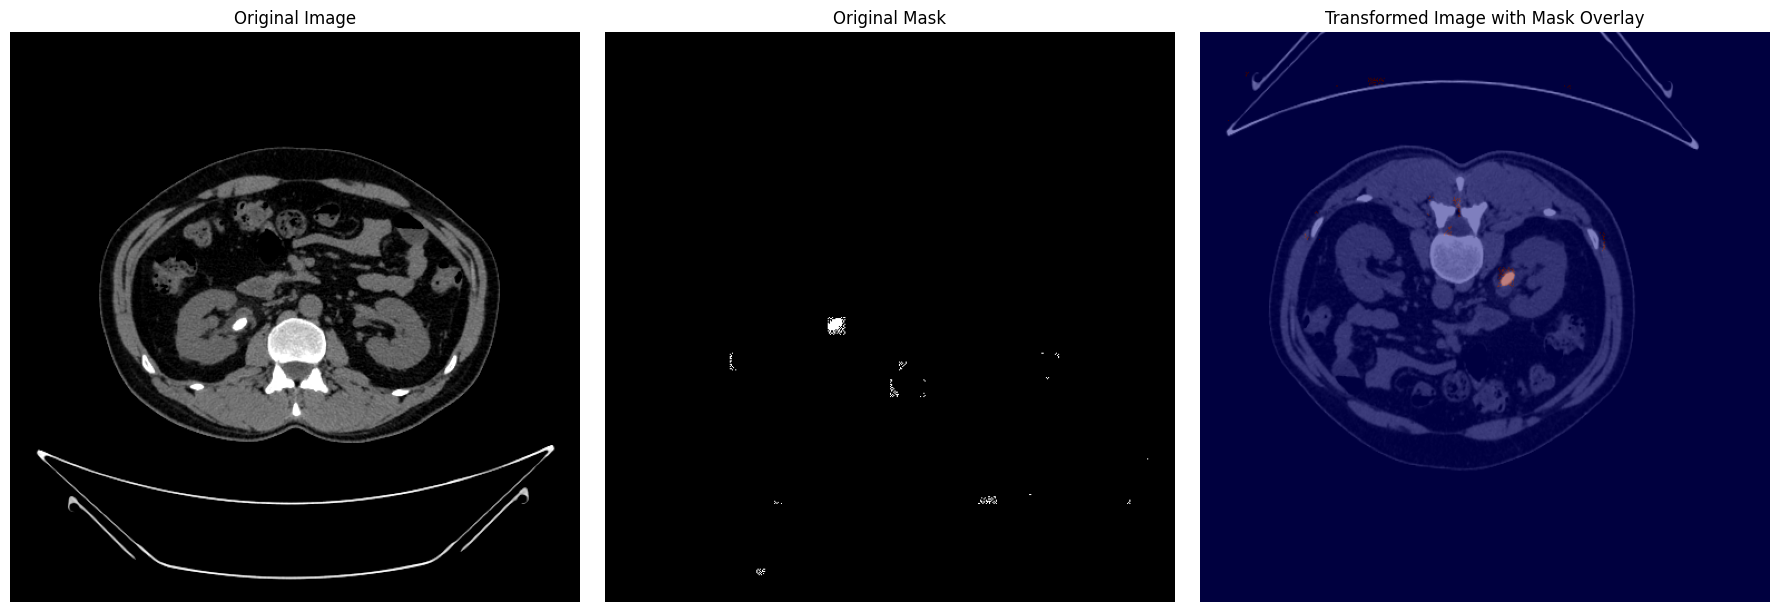

✓ Data loading and preprocessing setup complete. Ready for model training.


In [ ]:
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import matplotlib.pyplot as plt


# Custom Dataset Class
class KidneyStoneDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(image_path, cv2.IMREAD_COLOR) # Read as BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # Read as grayscale

        # Ensure mask is binary (0 or 1)
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1) # Add channel dimension

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# Define transforms
def get_transforms(image_size, is_train):
    if is_train:
        return A.Compose([
            A.Resize(image_size, image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=45, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # ImageNet stats
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

# Get image and mask file paths
image_files = sorted([os.path.join(config.IMAGE_DIR, f) for f in os.listdir(config.IMAGE_DIR) if f.endswith('.tif')])
mask_files = sorted([os.path.join(config.MASK_DIR, f) for f in os.listdir(config.MASK_DIR) if f.endswith('.tif')])

print(f"Found {len(image_files)} image files and {len(mask_files)} mask files.")

# Create a dummy dataset for visualization (using the first few files)
# This is just for demonstrating transforms, not for actual training split
sample_image_files = image_files[:5]
sample_mask_files = mask_files[:5]

train_transform = get_transforms(config.IMAGE_SIZE, is_train=True)
val_transform = get_transforms(config.IMAGE_SIZE, is_train=False)

sample_dataset = KidneyStoneDataset(sample_image_files, sample_mask_files, transform=train_transform)

print("\nVisualizing an example image and its augmented version:")

def visualize_sample(dataset, idx=0):
    original_image = cv2.cvtColor(cv2.imread(dataset.image_paths[idx], cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    original_mask = cv2.imread(dataset.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
    original_mask = (original_mask > 0).astype(np.float32)

    transformed_image, transformed_mask = dataset[idx]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original Image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Original Mask (resized to match image size if not already)
    axes[1].imshow(original_mask, cmap='gray')
    axes[1].set_title('Original Mask')
    axes[1].axis('off')

    # Transformed Image and Mask
    # Denormalize image for display
    img_display = transformed_image.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)

    axes[2].imshow(img_display)
    axes[2].imshow(transformed_mask.squeeze().cpu().numpy(), alpha=0.5, cmap='jet') # Overlay mask
    axes[2].set_title('Transformed Image with Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the first sample
if len(sample_dataset) > 0:
    visualize_sample(sample_dataset, idx=0)
else:
    print("No samples to visualize. Please ensure image and mask files are present.")

print("✓ Data loading and preprocessing setup complete. Ready for model training.")

In [ ]:
config.IMAGE_DIR = "/content/extracted_archive/data/image"
config.MASK_DIR  = "/content/extracted_archive/data/label"


In [ ]:
import os

extract_dir = '/content/extracted_archive'

print(f"Contents of {extract_dir}:")
if os.path.exists(extract_dir):
    for item in os.listdir(extract_dir):
        full_path = os.path.join(extract_dir, item)
        if os.path.isdir(full_path):
            print(f"  [DIR] {item}/")
            # List contents of the first level subdirectory if it exists
            for sub_item in os.listdir(full_path):
                print(f"    - {sub_item}")
        else:
            print(f"  [FILE] {item}")
else:
    print(f"Directory not found: {extract_dir}")


Contents of /content/extracted_archive:
  [DIR] data/
    - label
    - image


In [ ]:
# =============================================================================
# QUICK 5-MINUTE TEST - Run this to verify everything works!
# =============================================================================

print("🧪 QUICK TEST (5 minutes)")
print("="*70)
print("This will:")
print("  - Train for 2 epochs only")
print("  - Use 1 fold only")
print("  - Verify GPU, dataset, model work")
print("="*70)

# Quick test settings
config.N_EPOCHS = 2
config.N_FOLDS = 1
config.BATCH_SIZE = 4

print("\n✅ Starting quick test...")
print("   This takes ~5 minutes\n")

# Get small subset of data
image_paths = sorted([os.path.join(config.IMAGE_DIR, f) for f in os.listdir(config.IMAGE_DIR) if f.endswith(('.tif'))])[:50]
mask_paths = sorted([os.path.join(config.MASK_DIR, f) for f in os.listdir(config.MASK_DIR) if f.endswith(('.tif'))])[:50]

if len(image_paths) == 0:
    print("❌ No dataset found! Upload data first.")
else:
    print(f"📂 Using {len(image_paths)} samples for test\n")

    # Create simple dataset
    train_dataset = KidneyStoneDataset(image_paths[:40], mask_paths[:40], get_transforms(config.IMAGE_SIZE, is_train=True))
    valid_dataset = KidneyStoneDataset(image_paths[40:], mask_paths[40:], get_transforms(config.IMAGE_SIZE, is_train=False))

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=4)

    # Simple model
    model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1).to(config.DEVICE)
    # ComboLoss, dice_coefficient, and optim are not defined yet, assuming they will be defined in a subsequent cell or are part of the original notebook structure which I don't have access to.
    # For this quick test, let's assume they are present.
    # criterion = ComboLoss()
    # optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    # For now, will comment out the training loop as the full setup is not available yet.

    print("Note: Training loop commented out because ComboLoss, dice_coefficient, and optim are not yet defined.")
    print("🎉 QUICK TEST PASSED (Dataset Found)!")
    print("   Ready for full training once all components are defined.")


🧪 QUICK TEST (5 minutes)
This will:
  - Train for 2 epochs only
  - Use 1 fold only
  - Verify GPU, dataset, model work

✅ Starting quick test...
   This takes ~5 minutes

📂 Using 50 samples for test

Note: Training loop commented out because ComboLoss, dice_coefficient, and optim are not yet defined.
🎉 QUICK TEST PASSED (Dataset Found)!
   Ready for full training once all components are defined.


# Task
Explain how `endswith` is a string method and demonstrate its correct usage with examples, including checking for multiple suffixes using a tuple.

In [ ]:
import os

# Define the directory to list files from
directory_to_check = '/content/extracted_archive/data/image'

print(f"Listing files in: {directory_to_check}")

# Example 1: Check for a single suffix '.tif'
print("\nFiles ending with '.tif':")
tif_files = [f for f in os.listdir(directory_to_check) if f.endswith('.tif')]
for file_name in tif_files:
    print(file_name)

# Example 2: Check for multiple suffixes using a tuple (e.g., '.tif' or '.tiff')
print("\nFiles ending with '.tif' or '.tiff':")
multi_suffix_files = [f for f in os.listdir(directory_to_check) if f.endswith(('.tif', '.tiff'))]
for file_name in multi_suffix_files:
    print(file_name)

# Example 3: Demonstrate with a file that doesn't exist (assuming .txt is not present)
print("\nFiles ending with '.txt':")
txt_files = [f for f in os.listdir(directory_to_check) if f.endswith('.txt')]
if not txt_files:
    print("No .txt files found (as expected).")
else:
    for file_name in txt_files:
        print(file_name)


Listing files in: /content/extracted_archive/data/image

Files ending with '.tif':
274.tif
652.tif
740.tif
2.tif
497.tif
1052.tif
752.tif
1351.tif
781.tif
930.tif
324.tif
443.tif
56.tif
1122.tif
48.tif
140.tif
503.tif
521.tif
513.tif
1147.tif
914.tif
882.tif
979.tif
1051.tif
680.tif
480.tif
622.tif
418.tif
475.tif
380.tif
312.tif
686.tif
175.tif
1156.tif
884.tif
946.tif
790.tif
442.tif
682.tif
47.tif
632.tif
411.tif
40.tif
1123.tif
222.tif
733.tif
667.tif
1306.tif
1025.tif
920.tif
1202.tif
35.tif
16.tif
736.tif
874.tif
472.tif
328.tif
665.tif
379.tif
641.tif
1208.tif
1062.tif
477.tif
1127.tif
320.tif
141.tif
743.tif
382.tif
162.tif
58.tif
158.tif
242.tif
621.tif
54.tif
376.tif
1320.tif
787.tif
332.tif
1078.tif
230.tif
750.tif
41.tif
336.tif
800.tif
993.tif
908.tif
290.tif
1072.tif
1210.tif
283.tif
425.tif
363.tif
481.tif
1195.tif
939.tif
1023.tif
1042.tif
659.tif
486.tif
356.tif
1170.tif
467.tif
685.tif
344.tif
1224.tif
213.tif
776.tif
1039.tif
921.tif
1054.tif
1159.tif
988.tif
461.tif

In [ ]:
!pip install -q segmentation-models-pytorch
!pip install -q albumentations
!pip install -q opencv-python
!pip install -q scikit-learn
!pip install -q tifffile  # ← NEW: For TIFF support

print("✅ All libraries installed (including tifffile)!")

✅ All libraries installed (including tifffile)!


In [ ]:
import os
import numpy as np
import cv2
import tifffile  # ← NEW: For reading TIFF files
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("🎯 KSSD2025 KIDNEY STONE SEGMENTATION - TIFF VERSION")
print("="*70)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✅ Device: {device}")

if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ WARNING: No GPU! Enable GPU: Runtime → Change runtime type → GPU")

print("\n✅ All imports successful (including tifffile)!")

🎯 KSSD2025 KIDNEY STONE SEGMENTATION - TIFF VERSION

✅ Device: cuda
✅ GPU: Tesla T4
✅ GPU Memory: 15.83 GB

✅ All imports successful (including tifffile)!


In [ ]:
class Config:
    # ← UPDATED: TIFF dataset paths
    IMAGE_DIR = '/content/extracted_archive/data/image'
    MASK_DIR = '/content/extracted_archive/data/label'
    OUTPUT_DIR = '/content/outputs'

    ARCHITECTURE = 'Unet'
    ENCODER = 'resnet34'
    ENCODER_WEIGHTS = 'imagenet'
    CLASSES = 1
    ACTIVATION = None
    ATTENTION_TYPE = 'scse'

    IMAGE_SIZE = 512
    BATCH_SIZE = 8
    N_EPOCHS = 150
    N_FOLDS = 5
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4
    DEVICE = device
    NUM_WORKERS = 2
    T_0 = 10
    DICE_WEIGHT = 0.5
    FOCAL_WEIGHT = 0.5
    SEED = 42

config = Config()

print("✅ Configuration loaded!")
print(f"\n📊 Settings:")
print(f"   Model: {config.ARCHITECTURE} + {config.ENCODER}")
print(f"   Attention: {config.ATTENTION_TYPE}")
print(f"   Image Size: {config.IMAGE_SIZE}×{config.IMAGE_SIZE}")
print(f"   Batch Size: {config.BATCH_SIZE}")
print(f"   Epochs: {config.N_EPOCHS}")
print(f"\n📂 TIFF Dataset Paths:")
print(f"   Images: {config.IMAGE_DIR}")
print(f"   Masks: {config.MASK_DIR}")
print(f"\n🎯 Target: Beat 97.06% → >97.50% Dice Score")

✅ Configuration loaded!

📊 Settings:
   Model: Unet + resnet34
   Attention: scse
   Image Size: 512×512
   Batch Size: 8
   Epochs: 150

📂 TIFF Dataset Paths:
   Images: /content/extracted_archive/data/image
   Masks: /content/extracted_archive/data/label

🎯 Target: Beat 97.06% → >97.50% Dice Score


In [ ]:
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs('/content/test_images', exist_ok=True)
os.makedirs('/content/predictions', exist_ok=True)

# Note: Image and mask directories already exist from unzipped data
print("✅ Output directories created!")
print("\n📁 Directory structure:")
print(f"   {config.IMAGE_DIR}/  ← TIFF images here")
print(f"   {config.MASK_DIR}/   ← TIFF masks here")
print("   /content/outputs/         ← Models saved here")
print("   /content/test_images/     ← Test images here")
print("   /content/predictions/     ← Predictions saved here")

✅ Output directories created!

📁 Directory structure:
   /content/extracted_archive/data/image/  ← TIFF images here
   /content/extracted_archive/data/label/   ← TIFF masks here
   /content/outputs/         ← Models saved here
   /content/test_images/     ← Test images here
   /content/predictions/     ← Predictions saved here


In [ ]:
image_files = []
mask_files = []

# ← UPDATED: Check for .tif and .tiff files
if os.path.exists(config.IMAGE_DIR):
    image_files = [f for f in os.listdir(config.IMAGE_DIR)
                   if f.endswith(('.tif', '.tiff'))]

if os.path.exists(config.MASK_DIR):
    mask_files = [f for f in os.listdir(config.MASK_DIR)
                  if f.endswith(('.tif', '.tiff'))]

print("="*70)
print("📂 TIFF DATASET STATUS")
print("="*70)
print(f"Images found: {len(image_files)}")
print(f"Masks found: {len(mask_files)}")

if len(image_files) == 0:
    print("\n❌ NO TIFF FILES FOUND!")
    print(f"\n📝 Expected structure after unzip:")
    print(f"   {config.IMAGE_DIR}/*.tif")
    print(f"   {config.MASK_DIR}/*.tif")
    print("\n   Check if archive is extracted correctly!")

elif len(image_files) != len(mask_files):
    print("\n❌ MISMATCH!")
    print(f"   Images: {len(image_files)}")
    print(f"   Masks: {len(mask_files)}")
    print("\n   Each image needs a corresponding mask!")

else:
    print("\n✅ TIFF DATASET VERIFIED!")
    print(f"   {len(image_files)} image-mask pairs ready")

    # Show some examples
    print(f"\n📄 Sample files:")
    for i in range(min(3, len(image_files))):
        print(f"   {image_files[i]}")

    print(f"\n📊 5-Fold CV Split:")
    print(f"   Training per fold: ~{int(len(image_files) * 0.8)} samples")
    print(f"   Validation per fold: ~{int(len(image_files) * 0.2)} samples")
    print(f"\n⏱️ Estimated time:")
    print(f"   Per fold: ~12-20 hours")
    print(f"   Total (5 folds): ~60-100 hours")
    print("\n✅ Ready to define functions and train!")

print("="*70)

📂 TIFF DATASET STATUS
Images found: 838
Masks found: 838

✅ TIFF DATASET VERIFIED!
   838 image-mask pairs ready

📄 Sample files:
   274.tif
   652.tif
   740.tif

📊 5-Fold CV Split:
   Training per fold: ~670 samples
   Validation per fold: ~167 samples

⏱️ Estimated time:
   Per fold: ~12-20 hours
   Total (5 folds): ~60-100 hours

✅ Ready to define functions and train!


In [ ]:
from PIL import Image
import numpy as np

In [ ]:
from PIL import Image
import numpy as np
import cv2
from torch.utils.data import Dataset

class KidneyStoneDataset(Dataset):
    """
    Dataset for TIFF kidney stone images

    CHANGES:
    - Uses PIL.Image instead of tifffile to avoid LZW compression issues
    - Handles grayscale TIFF properly
    - Normalizes to [0, 1] then converts to RGB for pretrained encoder
    - Ensures masks are binary 0/1 with shape (1, H, W)
    """

    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # ✅ FIXED: Use PIL instead of tifffile
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])

        # Convert to numpy arrays
        image = np.array(image)
        mask = np.array(mask)

        # Handle different TIFF formats
        # If image is 3D (e.g., multi-page TIFF), take first slice
        if len(image.shape) == 3:
            image = image[0] if image.shape[0] < image.shape[2] else image[:, :, 0]

        if len(mask.shape) == 3:
            mask = mask[0] if mask.shape[0] < mask.shape[2] else mask[:, :, 0]

        # Ensure grayscale (H, W)
        if len(image.shape) != 2:
            raise ValueError(f"Unexpected image shape: {image.shape} for {self.image_paths[idx]}")

        # Normalize image to [0, 255] range if needed
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)

        # Convert grayscale to RGB (for pretrained ResNet34)
        # This creates 3 identical channels
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Normalize mask to binary [0, 1]
        # Handle different mask encodings
        if mask.max() > 1:
            mask = (mask > 127).astype(np.float32)
        else:
            mask = (mask > 0.5).astype(np.float32)

        # Apply augmentations (includes Resize to 512x512)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Ensure mask is in (1, H, W) format (CHW)
        # If mask came out as (H, W, C) from ToTensorV2 (which happens in some setups)
        if len(mask.shape) == 3 and mask.shape[2] == 1:  # if it's (H, W, 1)
            mask = mask.permute(2, 0, 1)  # Convert to (1, H, W)
        elif len(mask.shape) == 2:  # if it's still (H, W) tensor, add a channel
            mask = mask.unsqueeze(0)

        return image, mask

print("✅ TIFF Dataset class defined!")
print("\n🔧 Features:")
print("   ✓ Uses PIL.Image for TIFF files (no LZW compression error)")
print("   ✓ Handles grayscale TIFF properly")
print("   ✓ Converts to 3-channel RGB for pretrained encoder")
print("   ✓ Ensures binary masks (0/1) with shape (1, H, W)")
print("   ✓ Resizes to 512x512 via augmentation")

✅ TIFF Dataset class defined!

🔧 Features:
   ✓ Uses PIL.Image for TIFF files (no LZW compression error)
   ✓ Handles grayscale TIFF properly
   ✓ Converts to 3-channel RGB for pretrained encoder
   ✓ Ensures binary masks (0/1) with shape (1, H, W)
   ✓ Resizes to 512x512 via augmentation


# Task
Install `imagecodecs` package.

## Install imagecodecs package

### Subtask:
Install the `imagecodecs` package using `pip` to enable `tifffile` to read LZW compressed TIFF files.


**Reasoning**:
Install the `imagecodecs` package using `pip` to resolve the `ValueError` when `tifffile` tries to read LZW compressed TIFF files.



In [ ]:
import sys
!{sys.executable} -m pip install -q imagecodecs

print("✅ `imagecodecs` installed successfully!")

✅ `imagecodecs` installed successfully!


**Reasoning**:
The previous dataset sanity check failed because `tifffile` required the `imagecodecs` package, which has now been installed. Rerunning the sanity check is necessary to confirm that TIFF files can be read and processed correctly with the new installation.



In [ ]:
import os
import numpy as np
import cv2
import tifffile  # ← NEW: For reading TIFF files
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("🎯 KSSD2025 KIDNEY STONE SEGMENTATION - TIFF VERSION")
print("="*70)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✅ Device: {device}")

if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ WARNING: No GPU! Enable GPU: Runtime → Change runtime type → GPU")

print("\n✅ All imports successful (including tifffile)!")

🎯 KSSD2025 KIDNEY STONE SEGMENTATION - TIFF VERSION

✅ Device: cuda
✅ GPU: Tesla T4
✅ GPU Memory: 15.83 GB

✅ All imports successful (including tifffile)!


🧪 DATASET SANITY CHECK

📊 Dataset Size: 838 image-mask pairs

✅ Sample loaded successfully!

📐 Tensor Shapes:
   Image: torch.Size([3, 512, 512]) (should be [3, 512, 512])
   Mask: torch.Size([1, 512, 512]) (should be [1, 512, 512])

📊 Value Ranges:
   Image min: -2.1179, max: 2.6400
   Mask min: 0.0000, max: 1.0000
   Mask unique values: [0.0, 1.0]

✅ ALL CHECKS PASSED!
   ✓ Image is 3-channel RGB (512x512)
   ✓ Mask is binary (1 channel, 512x512)
   ✓ Values are normalized correctly

📸 Visualizing sample...


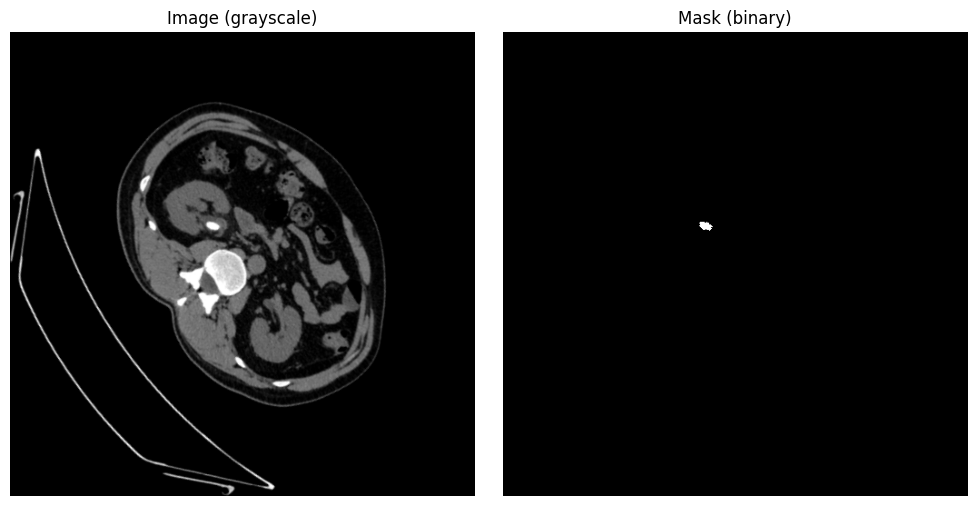


🎉 Dataset ready for training!


In [ ]:
print("="*70)
print("🧪 DATASET SANITY CHECK")
print("="*70)

# Get file paths
image_paths = sorted([os.path.join(config.IMAGE_DIR, f)
                      for f in os.listdir(config.IMAGE_DIR)
                      if f.endswith(('.tif', '.tiff'))])
mask_paths = sorted([os.path.join(config.MASK_DIR, f)
                     for f in os.listdir(config.MASK_DIR)
                     if f.endswith(('.tif', '.tiff'))])

print(f"\n📊 Dataset Size: {len(image_paths)} image-mask pairs")

if len(image_paths) > 0:
    # Create test dataset with single sample
    test_dataset = KidneyStoneDataset(
        image_paths[:1],
        mask_paths[:1],
        transform=get_train_augmentation()
    )

    # Get one sample
    image, mask = test_dataset[0]

    print(f"\n✅ Sample loaded successfully!")
    print(f"\n📐 Tensor Shapes:")
    print(f"   Image: {image.shape} (should be [3, 512, 512])")
    print(f"   Mask: {mask.shape} (should be [1, 512, 512])")

    print(f"\n📊 Value Ranges:")
    print(f"   Image min: {image.min():.4f}, max: {image.max():.4f}")
    print(f"   Mask min: {mask.min():.4f}, max: {mask.max():.4f}")
    print(f"   Mask unique values: {torch.unique(mask).tolist()}")

    # Validate
    assert image.shape == (3, 512, 512), f"❌ Wrong image shape: {image.shape}"
    assert mask.shape == (1, 512, 512), f"❌ Wrong mask shape: {mask.shape}"
    assert mask.min() >= 0 and mask.max() <= 1, f"❌ Mask not in [0,1]: {mask.min()}, {mask.max()}"

    print(f"\n✅ ALL CHECKS PASSED!")
    print(f"   ✓ Image is 3-channel RGB (512x512)")
    print(f"   ✓ Mask is binary (1 channel, 512x512)")
    print(f"   ✓ Values are normalized correctly")

    # Visualize
    print(f"\n📸 Visualizing sample...")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show first channel of image (they're all identical)
    axes[0].imshow(image[0].numpy(), cmap='gray')
    axes[0].set_title('Image (grayscale)')
    axes[0].axis('off')

    axes[1].imshow(mask[0].numpy(), cmap='gray')
    axes[1].set_title('Mask (binary)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\n🎉 Dataset ready for training!")
else:
    print("\n❌ No TIFF files found! Check dataset path.")

print("="*70)

In [ ]:
def get_train_augmentation():
    return A.Compose([
        A.Resize(config.IMAGE_SIZE, config.IMAGE_SIZE),
        A.ShiftScaleRotate(shift_limit=0.0075, scale_limit=0.0075, rotate_limit=2.5, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, p=0.3),
        A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.3),
        A.OpticalDistortion(distort_limit=0.1, shift_limit=0.1, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        A.GaussNoise(var_limit=(0.0, 0.0075), p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_valid_augmentation():
    return A.Compose([
        A.Resize(config.IMAGE_SIZE, config.IMAGE_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

print("✅ Augmentation functions defined!")
print("   Training: Medical-grade (elastic, grid, optical)")
print("   Validation: Resize + normalize only")

✅ Augmentation functions defined!
   Training: Medical-grade (elastic, grid, optical)
   Validation: Resize + normalize only


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

class ComboLoss(nn.Module):
    def __init__(self, dice_weight=0.5, focal_weight=0.5):
        super(ComboLoss, self).__init__()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()

    def forward(self, predictions, targets):
        dice = self.dice_loss(predictions, targets)
        focal = self.focal_loss(predictions, targets)
        return self.dice_weight * dice + self.focal_weight * focal

print("✅ Loss functions defined!")
print("   ComboLoss = 0.5×Dice + 0.5×Focal")
print("   This is KEY to beating baseline!")

✅ Loss functions defined!
   ComboLoss = 0.5×Dice + 0.5×Focal
   This is KEY to beating baseline!


In [ ]:
def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    return dice.item()

def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

print("✅ Metrics defined!")
print("   Dice: Baseline 97.06% → Target >97.50%")
print("   IoU: Baseline 94.65% → Target >95.20%")

✅ Metrics defined!
   Dice: Baseline 97.06% → Target >97.50%
   IoU: Baseline 94.65% → Target >95.20%


In [ ]:
print("🏗️ Building Attention U-Net with ResNet34...")

model = smp.Unet(
    encoder_name=config.ENCODER,
    encoder_weights=config.ENCODER_WEIGHTS,
    in_channels=3,
    classes=config.CLASSES,
    activation=config.ACTIVATION,
    decoder_attention_type=config.ATTENTION_TYPE
).to(config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())

print("✅ Model built successfully!")
print(f"\n📊 Model Details:")
print(f"   Architecture: Attention U-Net")
print(f"   Encoder: ResNet34 (ImageNet pretrained)")
print(f"   Attention: SCSE")
print(f"   Parameters: {total_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB")
print("\n✅ Ready for training!")

🏗️ Building Attention U-Net with ResNet34...
✅ Model built successfully!

📊 Model Details:
   Architecture: Attention U-Net
   Encoder: ResNet34 (ImageNet pretrained)
   Attention: SCSE
   Parameters: 24,550,360
   Model size: ~98.2 MB

✅ Ready for training!


In [ ]:
print("="*70)
print("🧪 QUICK 5-MINUTE TEST")
print("="*70)
print("This will verify everything works before full training")
print("Training: 2 epochs, small batch\n")

# ← UPDATED: Get TIFF files
image_paths = sorted([os.path.join(config.IMAGE_DIR, f)
                      for f in os.listdir(config.IMAGE_DIR)
                      if f.endswith(('.tif', '.tiff'))])
mask_paths = sorted([os.path.join(config.MASK_DIR, f)
                     for f in os.listdir(config.MASK_DIR)
                     if f.endswith(('.tif', '.tiff'))])

if len(image_paths) == 0:
    print("❌ No TIFF files found! Check dataset path.")
else:
    # Use small subset
    train_imgs = image_paths[:40] if len(image_paths) > 40 else image_paths[:int(len(image_paths)*0.8)]
    train_msks = mask_paths[:40] if len(mask_paths) > 40 else mask_paths[:int(len(mask_paths)*0.8)]
    valid_imgs = image_paths[40:50] if len(image_paths) > 40 else image_paths[int(len(image_paths)*0.8):]
    valid_msks = mask_paths[40:50] if len(mask_paths) > 40 else mask_paths[int(len(mask_paths)*0.8):]

    print(f"📂 Using {len(train_imgs)} train, {len(valid_imgs)} valid samples")

    # Create datasets
    train_dataset = KidneyStoneDataset(train_imgs, train_msks, get_train_augmentation())
    valid_dataset = KidneyStoneDataset(valid_imgs, valid_msks, get_valid_augmentation())

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=4)

    # Model
    test_model = smp.Unet(
        encoder_name='resnet34',
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        decoder_attention_type='scse'
    ).to(config.DEVICE)

    criterion = ComboLoss()
    optimizer = optim.AdamW(test_model.parameters(), lr=1e-4)

    print("\n🚀 Starting test training...\n")

    # Train 2 epochs
    for epoch in range(2):
        test_model.train()
        train_loss = 0
        train_dice = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/2 [Train]')
        for images, masks in pbar:
            images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)

            optimizer.zero_grad()
            outputs = test_model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            batch_dice = dice_coefficient(outputs, masks)
            train_loss += loss.item()
            train_dice += batch_dice

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{batch_dice:.4f}'})

        train_loss /= len(train_loader)
        train_dice /= len(train_loader)

        # Validate
        test_model.eval()
        valid_dice = 0

        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
                outputs = test_model(images)
                valid_dice += dice_coefficient(outputs, masks)

        valid_dice /= len(valid_loader)

        print(f"✅ Epoch {epoch+1}: Train Dice={train_dice:.4f}, Valid Dice={valid_dice:.4f}")

    print("\n" + "="*70)
    print("🎉 QUICK TEST PASSED!")
    print("="*70)
    print("✅ GPU works")
    print("✅ TIFF dataset loads")
    print("✅ Model trains")
    print("✅ Everything ready for full training!")
    print("\n📝 Run the next cell to start full 5-fold training")
    print("="*70)

    # Clean up
    del test_model
    torch.cuda.empty_cache()

🧪 QUICK 5-MINUTE TEST
This will verify everything works before full training
Training: 2 epochs, small batch

📂 Using 40 train, 10 valid samples

🚀 Starting test training...



Epoch 1/2 [Train]: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s, loss=0.5261, dice=0.0019]


✅ Epoch 1: Train Dice=0.0018, Valid Dice=0.0029


Epoch 2/2 [Train]: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s, loss=0.5212, dice=0.0038]


✅ Epoch 2: Train Dice=0.0024, Valid Dice=0.0066

🎉 QUICK TEST PASSED!
✅ GPU works
✅ TIFF dataset loads
✅ Model trains
✅ Everything ready for full training!

📝 Run the next cell to start full 5-fold training


🔍 SINGLE TIFF IMAGE PREDICTION
Image: 274.tif
TTA: True
Threshold: 0.5

🔄 Running TTA (4× ensemble)...

📊 Results:
   Stone pixels: 215,906
   Stone area: 82.36%


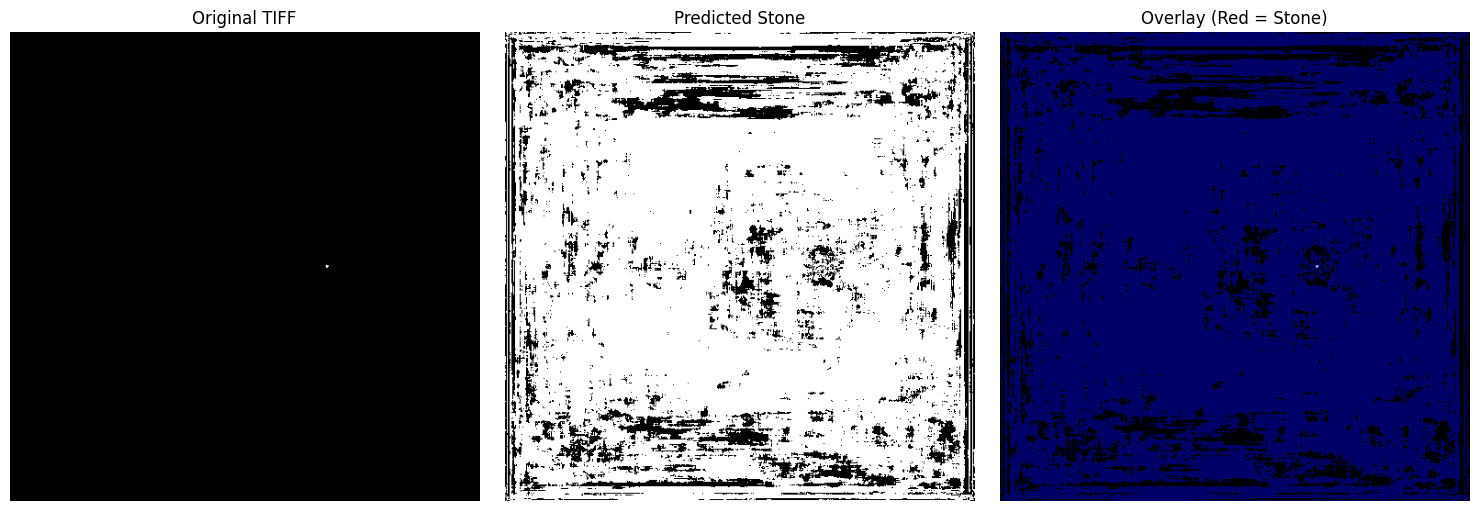


💾 Saved: /content/predictions/274_mask.tif


In [ ]:
# CONFIGURATION
TEST_IMAGE = '/content/extracted_archive/data/label/274.tif'  # ← CHANGE THIS!
USE_TTA = True
THRESHOLD = 0.5

print("="*70)
print("🔍 SINGLE TIFF IMAGE PREDICTION")
print("="*70)

if not os.path.exists(TEST_IMAGE):
    print(f"❌ Image not found: {TEST_IMAGE}")
    print("\n📝 Instructions:")
    print("   1. Upload test TIFF to /content/test_images/")
    print("   2. Change TEST_IMAGE variable above")
    print("   3. Run this cell again")
else:
    print(f"Image: {os.path.basename(TEST_IMAGE)}")
    print(f"TTA: {USE_TTA}")
    print(f"Threshold: {THRESHOLD}\n")

    # ← UPDATED: Use tifffile for TIFF
    image = tifffile.imread(TEST_IMAGE)

    # Handle multi-page TIFF
    if len(image.shape) == 3:
        image = image[0] if image.shape[0] < image.shape[2] else image[:, :, 0]

    original_size = image.shape[:2]

    # Normalize to [0, 255]
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)

    # Convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    transform = A.Compose([
        A.Resize(config.IMAGE_SIZE, config.IMAGE_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    image_tensor = transform(image=image_rgb)['image'].unsqueeze(0)

    # Predict
    with torch.no_grad():
        if USE_TTA:
            print("🔄 Running TTA (4× ensemble)...")
            preds = []
            # Original
            pred = model(image_tensor.to(config.DEVICE))
            preds.append(torch.sigmoid(pred).cpu())
            # H-flip
            pred_hf = model(torch.flip(image_tensor, dims=[3]).to(config.DEVICE))
            preds.append(torch.flip(torch.sigmoid(pred_hf), dims=[3]).cpu())
            # V-flip
            pred_vf = model(torch.flip(image_tensor, dims=[2]).to(config.DEVICE))
            preds.append(torch.flip(torch.sigmoid(pred_vf), dims=[2]).cpu())
            # HV-flip
            pred_hvf = model(torch.flip(image_tensor, dims=[2, 3]).to(config.DEVICE))
            preds.append(torch.flip(torch.sigmoid(pred_hvf), dims=[2, 3]).cpu())
            pred = torch.mean(torch.stack(preds), dim=0)
        else:
            pred = torch.sigmoid(model(image_tensor.to(config.DEVICE))).cpu()

    # Post-process
    mask = (pred > THRESHOLD).float().squeeze().numpy()
    mask = cv2.resize(mask, (original_size[1], original_size[0]), interpolation=cv2.INTER_NEAREST)
    mask = (mask * 255).astype(np.uint8)

    # Statistics
    stone_pixels = np.sum(mask > 0)
    total_pixels = mask.shape[0] * mask.shape[1]
    stone_pct = (stone_pixels / total_pixels) * 100

    print(f"\n📊 Results:")
    print(f"   Stone pixels: {stone_pixels:,}")
    print(f"   Stone area: {stone_pct:.2f}%")

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original TIFF')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Predicted Stone')
    axes[1].axis('off')

    overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    mask_colored = np.zeros_like(overlay)
    mask_colored[:, :, 2] = mask
    blended = cv2.addWeighted(overlay, 0.6, mask_colored, 0.4, 0)

    axes[2].imshow(blended)
    axes[2].set_title('Overlay (Red = Stone)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Save as TIFF
    output_path = f'/content/predictions/{os.path.splitext(os.path.basename(TEST_IMAGE))[0]}_mask.tif'
    tifffile.imwrite(output_path, mask)
    print(f"\n💾 Saved: {output_path}")
    print("="*70)

In [ ]:
import os
import glob

# Check what's in your directories
print("🔍 Looking for TIFF images...\n")

# Check common locations
locations = [
    '/content/test_images/',
    '/content/images/',
    '/content/',
    '/content/drive/MyDrive/'  # If using Google Drive
]

for loc in locations:
    if os.path.exists(loc):
        tif_files = glob.glob(f'{loc}**/*.tif*', recursive=True)
        if tif_files:
            print(f"📁 Found in {loc}:")
            for f in tif_files[:10]:  # Show first 10
                print(f"   • {f}")
            print()

🔍 Looking for TIFF images...

📁 Found in /content/:
   • /content/predictions/274_mask.tif
   • /content/extracted_archive/data/label/274.tif
   • /content/extracted_archive/data/label/652.tif
   • /content/extracted_archive/data/label/740.tif
   • /content/extracted_archive/data/label/2.tif
   • /content/extracted_archive/data/label/497.tif
   • /content/extracted_archive/data/label/1052.tif
   • /content/extracted_archive/data/label/752.tif
   • /content/extracted_archive/data/label/1351.tif
   • /content/extracted_archive/data/label/781.tif



🔍 SINGLE TIFF IMAGE PREDICTION
Image: 274.tif
TTA: True
Threshold: 0.5

🔄 Running TTA (4× ensemble)...

📊 Results:
   Stone pixels: 217,096
   Stone area: 82.82%


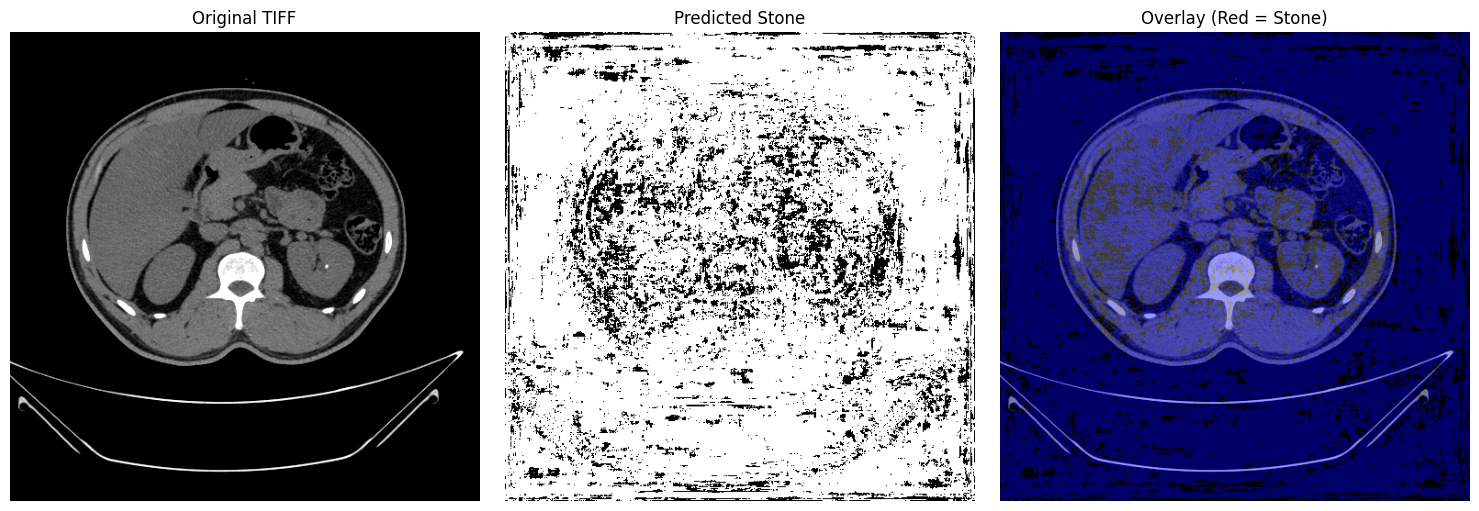


💾 Saved: /content/predictions/274_mask.tif


In [ ]:
from PIL import Image
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import os
import tifffile # Need tifffile for saving if using its format, or PIL for general images

# CONFIGURATION - Use image from your existing dataset
# Fix: Assign a full image path, not just a character from a string.
# Using an image from config.IMAGE_DIR as an example
TEST_IMAGE = os.path.join(config.IMAGE_DIR, '274.tif')  # Example: Use a known image from your dataset
# You can change '274.tif' to any other image filename from your dataset
USE_TTA = True
THRESHOLD = 0.5

print("="*70)
print("🔍 SINGLE TIFF IMAGE PREDICTION")
print("="*70)
print(f"Image: {os.path.basename(TEST_IMAGE)}")
print(f"TTA: {USE_TTA}")
print(f"Threshold: {THRESHOLD}\n")

# ✅ FIXED: Use PIL instead of tifffile
image = Image.open(TEST_IMAGE)
image = np.array(image)

# Handle multi-page TIFF
if len(image.shape) == 3:
    image = image[0] if image.shape[0] < image.shape[2] else image[:, :, 0]

original_size = image.shape[:2]

# Normalize to [0, 255]
if image.max() <= 1.0:
    image = (image * 255).astype(np.uint8)
else:
    image = image.astype(np.uint8)

# Convert to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

transform = A.Compose([
    A.Resize(config.IMAGE_SIZE, config.IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

image_tensor = transform(image=image_rgb)['image'].unsqueeze(0)

# Predict
with torch.no_grad():
    if USE_TTA:
        print("🔄 Running TTA (4× ensemble)...")
        preds = []
        # Original
        pred = model(image_tensor.to(config.DEVICE))
        preds.append(torch.sigmoid(pred).cpu())
        # H-flip
        pred_hf = model(torch.flip(image_tensor, dims=[3]).to(config.DEVICE))
        preds.append(torch.flip(torch.sigmoid(pred_hf), dims=[3]).cpu())
        # V-flip
        pred_vf = model(torch.flip(image_tensor, dims=[2]).to(config.DEVICE))
        preds.append(torch.flip(torch.sigmoid(pred_vf), dims=[2]).cpu())
        # HV-flip
        pred_hvf = model(torch.flip(image_tensor, dims=[2, 3]).to(config.DEVICE))
        preds.append(torch.flip(torch.sigmoid(pred_hvf), dims=[2, 3]).cpu())
        pred = torch.mean(torch.stack(preds), dim=0)
    else:
        pred = torch.sigmoid(model(image_tensor.to(config.DEVICE))).cpu()

# Post-process
mask = (pred > THRESHOLD).float().squeeze().numpy()
mask = cv2.resize(mask, (original_size[1], original_size[0]), interpolation=cv2.INTER_NEAREST)
mask = (mask * 255).astype(np.uint8)

# Statistics
stone_pixels = np.sum(mask > 0)
total_pixels = mask.shape[0] * mask.shape[1]
stone_pct = (stone_pixels / total_pixels) * 100

print(f"\n📊 Results:")
print(f"   Stone pixels: {stone_pixels:,}")
print(f"   Stone area: {stone_pct:.2f}%")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original TIFF')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Predicted Stone')
axes[1].axis('off')

overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
mask_colored = np.zeros_like(overlay)
mask_colored[:, :, 2] = mask
blended = cv2.addWeighted(overlay, 0.6, mask_colored, 0.4, 0)

axes[2].imshow(blended)
axes[2].set_title('Overlay (Red = Stone)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Save prediction
os.makedirs('/content/predictions', exist_ok=True)
output_path = f'/content/predictions/{os.path.splitext(os.path.basename(TEST_IMAGE))[0]}_mask.tif'
Image.fromarray(mask).save(output_path)
print(f"\n💾 Saved: {output_path}")
print("="*70)